In [1]:
import numpy as np
from EM import EM
from plot import plot
import matplotlib.pyplot as plt

In [2]:
# EM Setting
num_past_effects = 3
training_pct = .8
single_effect = False

In [3]:
data = np.load('../Data/inr_preprocessed_data.npz')

In [22]:
%%time
em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, 0, train_pct=training_pct, single_effect=single_effect)
em.run_EM(20)

/home/bear/Documents/Counterfactual-Prediction/EM.py:456: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.sigma_pred[n, index]+self.sigma_2))


max iterations: 20 reached
CPU times: user 1min 21s, sys: 36 ms, total: 1min 21s
Wall time: 1min 21s


In [23]:
em.get_MSE()

1.1820494900835885

In [24]:
treatment_types = ['nsaid', 'transfusion_plasma', 'transfusion_platelet', 'anticoagulant', 'aspirin']
for i, treatment in enumerate(treatment_types):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = ['chronic kidney failure', 'sickle cell', 'age']
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))

Coefficient for nsaid: [-0.01343042  0.06188978 -0.0206052 ]
Coefficient for transfusion_plasma: [-0.86879404 -0.10335074 -0.09654291]
Coefficient for transfusion_platelet: [-0.51971407 -0.25911799 -0.26322033]
Coefficient for anticoagulant: [-0.7737384 -0.9251602 -0.8082308]
Coefficient for aspirin: [-0.04910664 -0.04401215  0.07716922]
Coefficient for chronic kidney failure: -0.26205698527767574
Coefficient for sickle cell: -0.6897419487402043
Coefficient for age: -0.031631826948945146


In [25]:
random_patients = np.random.randint(0, em.y.shape[0], 0)
for i in random_patients:
    plot(em, i, time_unit=18)

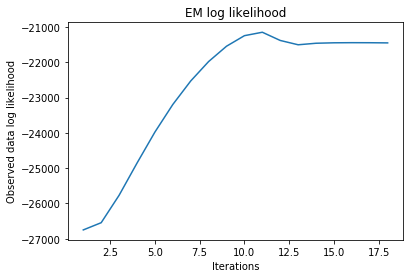

In [26]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [27]:
em.obs_log_lik

[-60778.179789624526,
 -26748.52435789301,
 -26544.016870065017,
 -25767.85416505135,
 -24856.88275972586,
 -23978.05241023926,
 -23196.842204409284,
 -22531.263593569445,
 -21981.03079964908,
 -21546.891632550534,
 -21248.427333312025,
 -21151.24127416959,
 -21383.738786127207,
 -21506.096752673686,
 -21462.896497848527,
 -21450.146175103117,
 -21446.770072118197,
 -21448.023744983937,
 -21452.861187961116,
 nan]